In [1]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20180306-3).
0 upgraded, 0 newly installed, 0 to remove and 23 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 31 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/n

In [3]:
!apt-get update -qq   # 폰트 설정을 위한 코드
!apt-get install fonts-nanum* -qq

In [4]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [41]:
import tqdm
import optuna
import warnings
import random, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import ExtraTreesClassifier, StackingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor
from supervised.automl import AutoML
from sklearn.metrics import f1_score
warnings.filterwarnings("ignore")

In [6]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42)

In [7]:
train = pd.read_csv('/content/drive/MyDrive/competition/call_cancel_clf/train.csv')
test = pd.read_csv('/content/drive/MyDrive/competition/call_cancel_clf/test.csv')
sub = pd.read_csv('/content/drive/MyDrive/competition/call_cancel_clf/sample_submission.csv')

In [8]:
train = train.drop(columns='ID')
print(train.columns)
train.head()

Index(['가입일', '음성사서함이용', '주간통화시간', '주간통화횟수', '주간통화요금', '저녁통화시간', '저녁통화횟수',
       '저녁통화요금', '밤통화시간', '밤통화횟수', '밤통화요금', '상담전화건수', '전화해지여부'],
      dtype='object')


,가입일,음성사서함이용,주간통화시간,주간통화횟수,주간통화요금,저녁통화시간,저녁통화횟수,저녁통화요금,밤통화시간,밤통화횟수,밤통화요금,상담전화건수,전화해지여부
0,329,0,99.2,93,27.3,268.8,68,28.92,262.9,328,32.89,2,0
1,2,80,323.9,323,83.7,269.4,326,32.09,322.8,209,32.32,2,0
2,93,28,282.4,323,34.2,207.0,322,32.82,280.8,328,8.28,0,0
3,223,1,221.4,223,25.1,233.0,61,23.90,203.8,234,9.36,0,0
4,222,0,96.3,222,28.7,223.9,69,28.08,263.1,223,2.80,8,0


In [9]:
# 시간 데이터 통일
# 주간/저녁/밤 --> 각각 8시간 --> 480분
# 480분이 넘어가는 데이터가 존재
train[train['주간통화시간'] > 480.0]

,가입일,음성사서함이용,주간통화시간,주간통화횟수,주간통화요금,저녁통화시간,저녁통화횟수,저녁통화요금,밤통화시간,밤통화횟수,밤통화요금,상담전화건수,전화해지여부
1966,97,1,480.3,444,50.4,450.2,447,48.84,444.9,90,9.86,8,0
2549,58,49,480.2,444,49.2,446.5,410,48.96,455.3,95,44.55,4,0
2933,409,1,480.6,400,52.3,450.6,405,49.47,459.6,405,6.47,5,0
3237,95,56,480.3,454,51.9,479.9,404,45.48,447.0,84,5.74,4,0
3385,91,1,480.2,78,52.4,441.1,99,47.94,478.5,58,44.46,4,0
3907,67,0,480.1,445,51.0,475.6,86,44.74,476.4,97,44.48,0,0
5201,470,0,480.5,444,51.2,476.6,451,44.89,449.9,94,40.49,4,0
5769,444,1,480.3,89,52.3,445.7,77,44.55,456.9,441,40.54,4,0
6321,441,1,481.1,80,82.0,445.3,84,49.06,469.3,94,44.94,8,0
9628,85,1,481.9,446,48.8,406.0,90,47.49,457.3,405,7.06,0,1


In [10]:
train[train['저녁통화시간'] > 480.0]

,가입일,음성사서함이용,주간통화시간,주간통화횟수,주간통화요금,저녁통화시간,저녁통화횟수,저녁통화요금,밤통화시간,밤통화횟수,밤통화요금,상담전화건수,전화해지여부
146,48,0,49.4,441,10.4,480.8,446,45.44,456.0,96,6.87,0,1
2055,450,55,451.2,404,42.1,480.7,88,45.69,465.5,476,44.85,4,0
3521,440,0,450.1,445,49.6,481.4,99,48.80,440.1,449,6.80,4,0
5247,444,1,447.3,99,45.8,480.1,64,48.80,441.6,449,6.84,4,0
6477,408,56,98.2,86,47.6,481.3,95,45.47,467.2,445,7.48,4,0
7045,405,1,99.9,444,50.8,480.5,405,44.48,445.8,446,40.88,4,0
10451,89,1,91.1,81,47.1,481.2,85,45.48,446.7,440,6.56,4,0
11106,97,0,446.8,90,59.2,481.4,447,45.76,456.7,405,40.54,0,1
13649,56,59,460.8,405,46.0,480.3,447,45.46,446.6,405,44.09,5,0
14306,56,1,455.9,406,45.4,481.2,444,45.77,481.4,74,8.40,0,0


In [11]:
train[train['밤통화시간'] > 480.0]

,가입일,음성사서함이용,주간통화시간,주간통화횟수,주간통화요금,저녁통화시간,저녁통화횟수,저녁통화요금,밤통화시간,밤통화횟수,밤통화요금,상담전화건수,전화해지여부
306,75,1,460.8,445,47.5,446.3,404,47.99,480.4,95,8.08,4,0
476,444,1,478.5,74,51.0,456.2,455,49.86,480.8,94,8.07,0,0
1441,444,1,459.0,404,47.1,446.2,78,47.95,480.2,404,8.07,5,0
2209,97,0,470.2,87,48.8,460.9,405,44.05,480.5,445,44.59,4,0
3344,455,0,94.4,81,47.6,446.8,404,48.48,481.5,408,8.09,4,0
4377,450,44,446.1,449,49.7,450.4,489,49.04,480.1,95,6.48,4,0
4968,56,54,455.1,66,45.7,448.3,445,49.55,480.2,405,8.05,4,0
5421,491,0,451.0,86,47.6,469.7,449,44.85,480.3,76,8.40,4,0
5787,450,45,444.5,449,50.8,449.0,488,49.04,481.8,95,6.48,4,0
6563,68,0,442.5,446,57.7,450.6,87,48.65,481.4,86,8.09,4,0


In [12]:
# 각 데이터를 480.0으로 대체
for col in ['주간통화시간', '저녁통화시간', '밤통화시간']:
  train.loc[train[col] > 480.0, col] = 480.0

train.head()

,가입일,음성사서함이용,주간통화시간,주간통화횟수,주간통화요금,저녁통화시간,저녁통화횟수,저녁통화요금,밤통화시간,밤통화횟수,밤통화요금,상담전화건수,전화해지여부
0,329,0,99.2,93,27.3,268.8,68,28.92,262.9,328,32.89,2,0
1,2,80,323.9,323,83.7,269.4,326,32.09,322.8,209,32.32,2,0
2,93,28,282.4,323,34.2,207.0,322,32.82,280.8,328,8.28,0,0
3,223,1,221.4,223,25.1,233.0,61,23.90,203.8,234,9.36,0,0
4,222,0,96.3,222,28.7,223.9,69,28.08,263.1,223,2.80,8,0


In [13]:
train.iloc[:, :-1].describe()

,가입일,음성사서함이용,주간통화시간,주간통화횟수,주간통화요금,저녁통화시간,저녁통화횟수,저녁통화요금,밤통화시간,밤통화횟수,밤통화요금,상담전화건수
count,30200.000000,30200.000000,30200.000000,30200.000000,30200.000000,30200.000000,30200.000000,30200.000000,30200.000000,30200.000000,30200.000000,30200.000000
mean,159.732649,12.037815,250.563000,159.175728,41.091447,263.246606,158.474536,25.394260,263.437593,157.047417,12.074648,2.288079
std,123.752781,24.925334,84.402105,101.573057,23.179017,74.063135,102.200293,8.146126,73.776380,101.721601,9.414261,2.050746
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,20.800000,20.000000,1.040000,0.000000
25%,63.000000,0.000000,222.800000,88.000000,24.400000,223.700000,87.000000,22.220000,223.700000,87.000000,4.700000,2.000000
50%,118.000000,1.000000,234.000000,117.500000,30.800000,243.000000,112.000000,23.320000,242.800000,108.000000,9.080000,2.000000
75%,228.000000,22.000000,289.600000,223.000000,45.900000,290.300000,223.000000,28.820000,290.500000,222.000000,20.290000,2.000000
max,2212.000000,1112.000000,480.000000,489.000000,118.600000,480.000000,489.000000,49.980000,480.000000,490.000000,44.980000,11.000000


0    26882
1     3318
Name: 전화해지여부, dtype: int64


<Axes: >

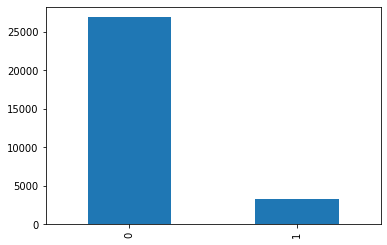

In [14]:
# 클래스 분포 확인 : 전화해지를 하지 않는 고객(0)이 더 많음!
print(train['전화해지여부'].value_counts())
train['전화해지여부'].value_counts().plot(kind='bar')

array([[<Axes: title={'center': '가입일'}>,
        <Axes: title={'center': '음성사서함이용'}>,
        <Axes: title={'center': '주간통화시간'}>],
       [<Axes: title={'center': '주간통화횟수'}>,
        <Axes: title={'center': '주간통화요금'}>,
        <Axes: title={'center': '저녁통화시간'}>],
       [<Axes: title={'center': '저녁통화횟수'}>,
        <Axes: title={'center': '저녁통화요금'}>,
        <Axes: title={'center': '밤통화시간'}>],
       [<Axes: title={'center': '밤통화횟수'}>,
        <Axes: title={'center': '밤통화요금'}>,
        <Axes: title={'center': '상담전화건수'}>]], dtype=object)

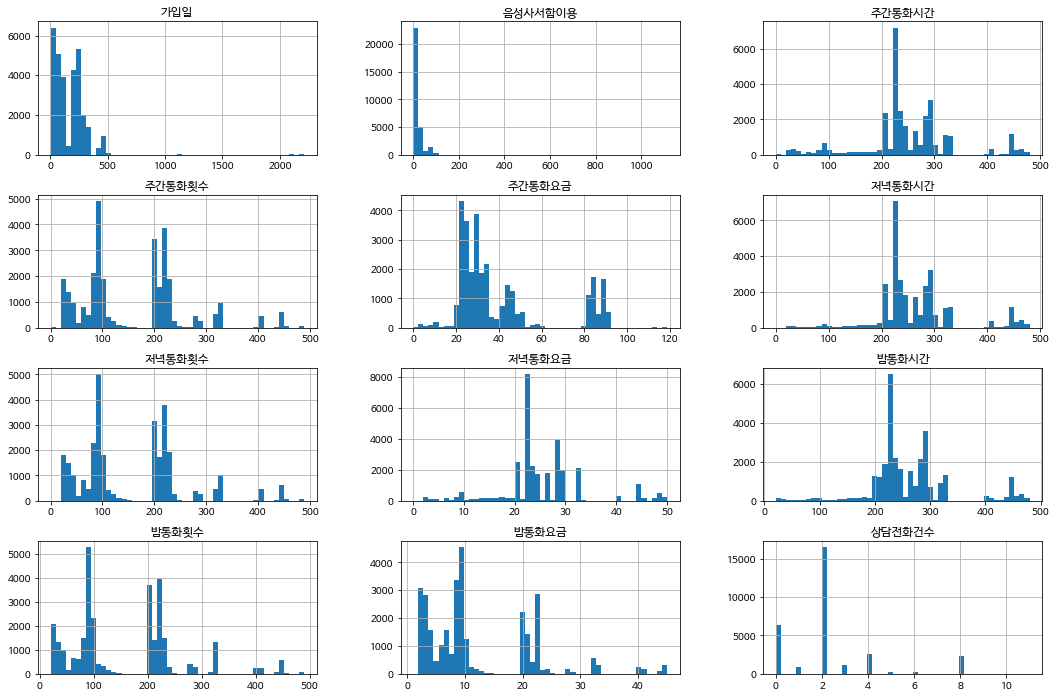

In [15]:
# 각 컬럼의 히스토그램 분포 확인
# voice_mail, apply_date의 오른쪽 꼬리가 긴 것 확인 가능

plt.rc('font', family='NanumBarunGothic')
train.iloc[:, :-1].hist(figsize=(18,12), bins=50)

In [16]:
# 변수별 skew 정도 체크
def check_skew(df=None):
  skewness = df.apply(lambda x: x.skew()).sort_values(ascending=False)
  return skewness

skewness = check_skew(train)

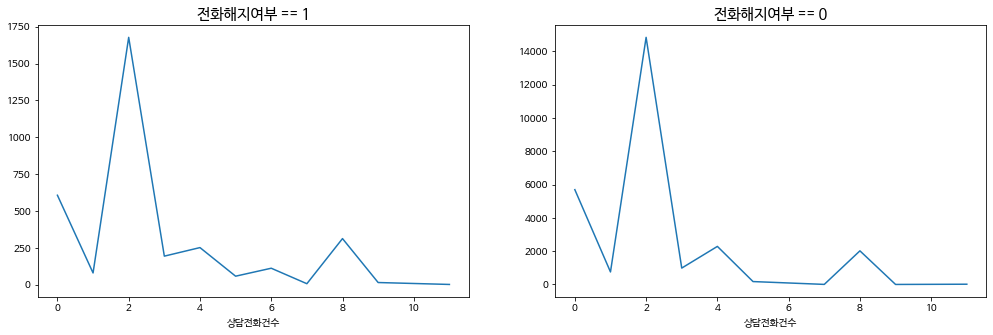

In [17]:
# 개별 클래스의 데이터 분포 확인 가능
# 전화해지하는 고객의 상담전화건수 횟수 확인
# 전화해지여부 == 1이든 0이든 큰 차이는 없음

plt.figure(figsize=(17,5))
plt.subplot(1,2,1)
plt.title('전화해지여부 == 1', fontsize=15)
cancel_consult_1 = train[train['전화해지여부'] == 1].groupby('상담전화건수')['전화해지여부'].count()
cancel_consult_1.plot()

plt.subplot(1,2,2)
plt.title('전화해지여부 == 0', fontsize=15)
cancel_consult_2 = train[train['전화해지여부'] == 0].groupby('상담전화건수')['전화해지여부'].count()
cancel_consult_2.plot()

plt.show()

In [18]:
train_stats = train.describe().T[['mean', 'max', '50%', '25%', '75%']]
train_stats['IQR'] = train_stats['75%'] - train_stats['25%']
train_stats['lowest_value'] = train_stats['25%'] - (train_stats['IQR'] * 1.5)
train_stats['highest_value'] = train_stats['75%'] + (train_stats['IQR'] * 1.5)
train_stats

,mean,max,50%,25%,75%,IQR,lowest_value,highest_value
가입일,159.732649,2212.00,118.00,63.00,228.00,165.00,-184.500,475.500
음성사서함이용,12.037815,1112.00,1.00,0.00,22.00,22.00,-33.000,55.000
주간통화시간,250.563000,480.00,234.00,222.80,289.60,66.80,122.600,389.800
주간통화횟수,159.175728,489.00,117.50,88.00,223.00,135.00,-114.500,425.500
주간통화요금,41.091447,118.60,30.80,24.40,45.90,21.50,-7.850,78.150
저녁통화시간,263.246606,480.00,243.00,223.70,290.30,66.60,123.800,390.200
저녁통화횟수,158.474536,489.00,112.00,87.00,223.00,136.00,-117.000,427.000
저녁통화요금,25.394260,49.98,23.32,22.22,28.82,6.60,12.320,38.720
밤통화시간,263.437593,480.00,242.80,223.70,290.50,66.80,123.500,390.700
밤통화횟수,157.047417,490.00,108.00,87.00,222.00,135.00,-115.500,424.500


In [19]:
# 이상치 확인
# 확실히 왜도 값이 높은 pressure, precipitation, wind_speed에 대해 이상치 값이 많이 나오기는 함

def check_outliers(df, weight=1.5):
  '''
  연속형 변수(Snowing 빼고 전부)에 대해 이상치 확인
  '''
  df = df.copy()
  num_cols = ['음성사서함이용','가입일','상담전화건수','밤통화요금','주간통화요금']

  for col in num_cols:
    data = df[col]
    quantile_25 = np.percentile(data.values, 25)
    quantile_75 = np.percentile(data.values, 75)

    iqr = quantile_75 - quantile_25
    iqr_weights = iqr * weight

    lowest_value = quantile_25 - iqr_weights
    highest_value = quantile_75 + iqr_weights

    outlier_index = df[(data < lowest_value) | (data > highest_value)].index
    print(f'{col}의 이상치 인덱스 : ', '\t', list(outlier_index), '\n 이상치 개수', len(list(outlier_index)))
  
check_outliers(train)

음성사서함이용의 이상치 인덱스 :  	 [1, 49, 56, 97, 98, 99, 147, 176, 194, 196, 215, 216, 281, 284, 287, 294, 300, 310, 314, 359, 363, 366, 395, 437, 438, 452, 536, 556, 562, 571, 587, 588, 592, 600, 642, 666, 713, 717, 729, 757, 762, 771, 787, 804, 818, 832, 851, 855, 876, 942, 1026, 1075, 1077, 1117, 1146, 1172, 1189, 1190, 1210, 1218, 1231, 1235, 1273, 1295, 1298, 1331, 1338, 1348, 1350, 1351, 1354, 1383, 1398, 1412, 1431, 1432, 1442, 1471, 1485, 1493, 1498, 1505, 1528, 1529, 1535, 1544, 1546, 1558, 1569, 1580, 1581, 1603, 1620, 1642, 1662, 1669, 1673, 1699, 1706, 1707, 1710, 1776, 1790, 1793, 1797, 1803, 1816, 1822, 1867, 1876, 1877, 1879, 1891, 1904, 1913, 1923, 1931, 1944, 1959, 1979, 2045, 2065, 2070, 2085, 2135, 2138, 2145, 2161, 2180, 2195, 2203, 2228, 2237, 2250, 2254, 2276, 2282, 2319, 2369, 2371, 2401, 2402, 2418, 2440, 2445, 2459, 2489, 2502, 2513, 2533, 2560, 2569, 2599, 2612, 2619, 2620, 2676, 2685, 2688, 2704, 2734, 2742, 2761, 2916, 2948, 2951, 2967, 2968, 2973, 2986, 3009, 3040, 30

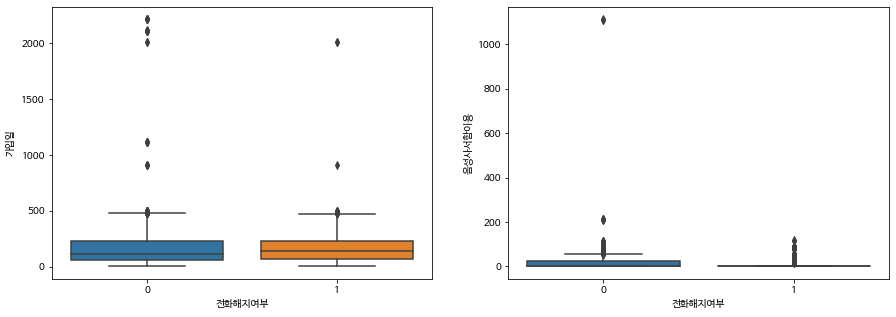

In [20]:
# boxplot을 사용한 이상치 탐지
# 각 클래스에 해당하는 그룹의 이상치 파악 가능
# 이상치(x>highest_value)는 IQR 값으로 대체하는게 좋을듯!
# 가입일의 highest_value = 475.5
# 음성사서함의 highest_value = 55 


plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.boxplot(x=train['전화해지여부'], y=train['가입일'])

plt.subplot(1,2,2)
sns.boxplot(x=train['전화해지여부'], y=train['음성사서함이용'])
plt.show()

In [21]:
# 가입일 이상치 214개
train[train['가입일'] > train_stats['highest_value']['가입일']]

,가입일,음성사서함이용,주간통화시간,주간통화횟수,주간통화요금,저녁통화시간,저녁통화횟수,저녁통화요금,밤통화시간,밤통화횟수,밤통화요금,상담전화건수,전화해지여부
61,488,0,444.9,489,45.1,449.1,444,49.4400,446.0,409,8.480,4,1
119,489,0,444.5,449,45.8,450.4,68,44.4800,444.8,84,9.840,4,0
361,485,1,445.5,405,45.7,469.8,95,44.8600,406.2,448,9.840,4,0
384,911,0,228.5,63,117.8,202.5,221,22.6110,223.1,221,9.911,2,1
405,2110,0,222.9,222,117.0,292.8,120,26.1111,223.8,99,20.920,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
29805,480,1,445.3,408,89.5,480.0,405,44.4800,448.4,48,9.440,8,0
29951,485,0,446.2,444,90.1,402.3,100,44.0600,447.6,448,8.480,4,0
30046,480,49,446.6,441,51.1,445.8,98,48.4900,441.5,64,9.940,4,0
30057,2113,30,230.3,202,114.1,207.2,209,22.1120,292.8,222,11.660,2,0


In [22]:
# 너무 많은 값이 음성사서함이용 컬럼의 이상치로 존재...
train[train['음성사서함이용'] > train_stats['highest_value']['음성사서함이용']]

,가입일,음성사서함이용,주간통화시간,주간통화횟수,주간통화요금,저녁통화시간,저녁통화횟수,저녁통화요금,밤통화시간,밤통화횟수,밤통화요금,상담전화건수,전화해지여부
1,2,80,323.9,323,83.7,269.4,326,32.09,322.8,209,32.320,2,0
49,83,89,263.9,223,22.9,229.7,91,20.26,263.7,202,22.260,2,0
56,201,81,90.6,202,20.0,330.6,202,28.66,284.2,329,6.880,0,0
97,286,89,209.2,207,84.6,284.2,100,28.98,203.7,202,2.880,8,0
98,29,82,293.1,203,89.6,226.6,83,22.96,282.1,220,20.880,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
30165,23,82,270.4,80,23.2,224.5,228,28.22,291.3,207,8.820,0,0
30168,223,113,222.7,202,30.4,223.7,93,29.06,227.0,93,11.211,2,0
30170,99,83,229.2,223,82.3,229.5,63,9.28,293.5,88,8.620,2,0
30195,263,80,289.6,201,21.8,280.5,323,29.88,208.0,66,9.280,2,0


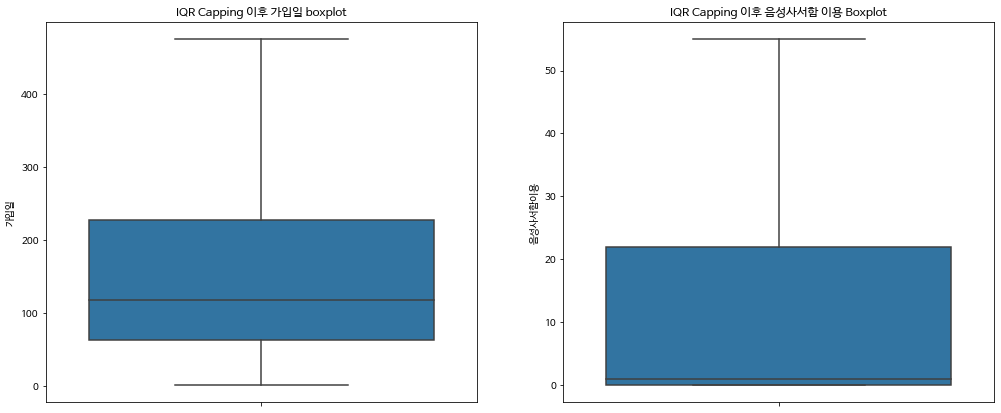

In [23]:
# 가입일의 highest_value = 475.5
# 음성사서함이용의 highest_value = 55 


for col in ['가입일', '음성사서함이용']:
  train.loc[train[col] >= train_stats['highest_value'][col], col] = train_stats['highest_value'][col]

plt.figure(figsize=(17,7))
plt.subplot(1,2,1)
plt.title('IQR Capping 이후 가입일 boxplot')
sns.boxplot(y='가입일', orient='v', data=train)

plt.subplot(1,2,2)
plt.title('IQR Capping 이후 음성사서함 이용 Boxplot')
sns.boxplot(y='음성사서함이용', orient='v', data=train)
plt.show()

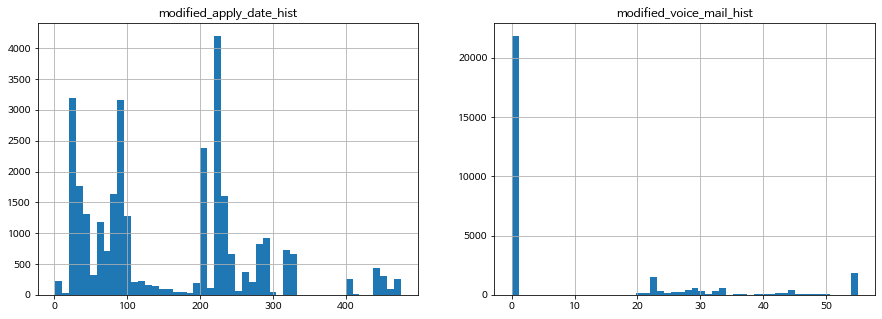

In [24]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.title('modified_apply_date_hist')
train['가입일'].hist(bins=50)

plt.subplot(1,2,2)
plt.title('modified_voice_mail_hist')
train['음성사서함이용'].hist(bins=50)
plt.show()

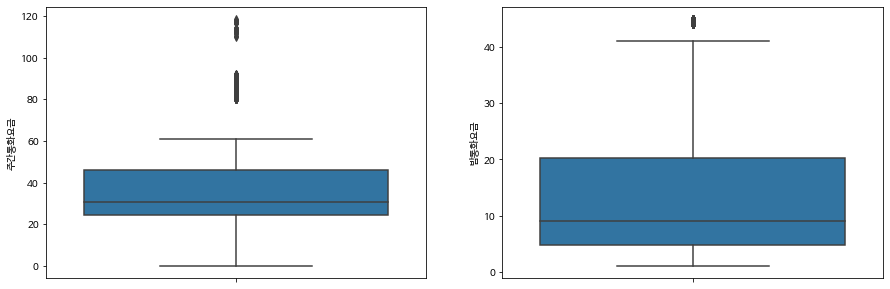

In [25]:
# 상담전화 건수 이상치에 대해서는 무시(애초에 데이터가 0~11)
# 주간통화요금 / 밤통화요금 체크

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.boxplot(y=train['주간통화요금'])

plt.subplot(1,2,2)
sns.boxplot(y=train['밤통화요금'])
plt.show()

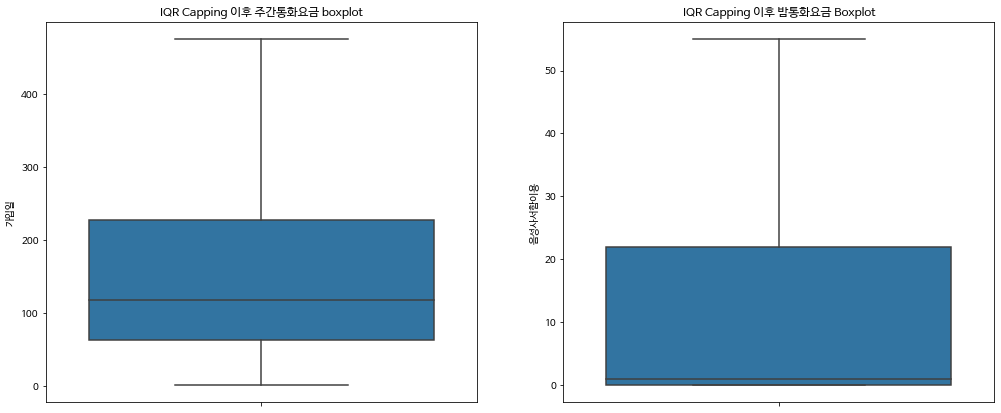

In [26]:
# 주간통화요금 | 밤통화요금 --> IQR Capping 처리
# 주간통화요금 highest_value = 78.15
# 밤통화요금 highest_value = 43.675


for col in ['주간통화요금', '밤통화요금']:
  train.loc[train[col] >= train_stats['highest_value'][col], col] = train_stats['highest_value'][col]

plt.figure(figsize=(17,7))
plt.subplot(1,2,1)
plt.title('IQR Capping 이후 주간통화요금 boxplot')
sns.boxplot(y='가입일', orient='v', data=train)

plt.subplot(1,2,2)
plt.title('IQR Capping 이후 밤통화요금 Boxplot')
sns.boxplot(y='음성사서함이용', orient='v', data=train)
plt.show()

In [27]:
skewness_modified = check_skew(train)
print(skewness,'\n\n')
print(skewness_modified)

음성사서함이용    10.159494
가입일         3.106704
전화해지여부      2.495178
상담전화건수      1.554562
밤통화요금       1.276195
주간통화요금      1.193922
밤통화횟수       0.808396
저녁통화횟수      0.801134
밤통화시간       0.782394
저녁통화시간      0.767998
주간통화횟수      0.766039
저녁통화요금      0.592813
주간통화시간      0.177759
dtype: float64 


전화해지여부     2.495178
상담전화건수     1.554562
음성사서함이용    1.515122
밤통화요금      1.253372
주간통화요금     1.046471
밤통화횟수      0.808396
저녁통화횟수     0.801134
밤통화시간      0.782394
저녁통화시간     0.767998
주간통화횟수     0.766039
가입일        0.655519
저녁통화요금     0.592813
주간통화시간     0.177759
dtype: float64


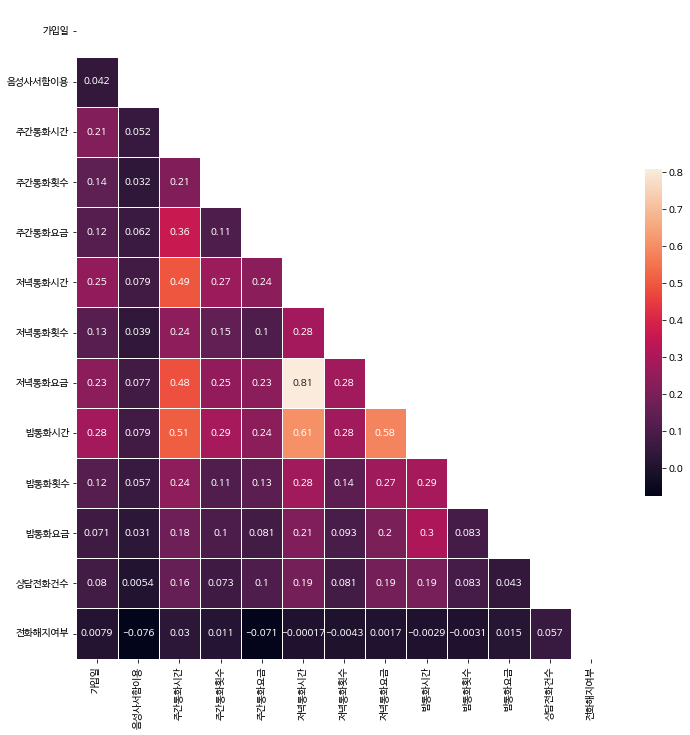



 전화해지여부     1.000000
상담전화건수     0.057114
주간통화시간     0.029974
밤통화요금      0.014600
주간통화횟수     0.010974
가입일        0.007944
저녁통화요금     0.001711
저녁통화시간    -0.000167
밤통화시간     -0.002872
밤통화횟수     -0.003121
저녁통화횟수    -0.004276
주간통화요금    -0.070628
음성사서함이용   -0.075636
Name: 전화해지여부, dtype: float64


In [28]:
# 상관관계 확인
# cancel에는 consult_count, week_call_time이 큰 영향을 미침
# 독립변수들 간 상관관계가 높은 경우가 존재함
# call_count, call_time --> call_bill

train_corr = train.corr()
mask = np.zeros_like(train_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize = (12,12))

sns.heatmap(train_corr, annot =True, mask=mask, linewidth = 1, cbar_kws={'shrink' : 0.5})
plt.show()

print('\n\n', train_corr['전화해지여부'].sort_values(ascending=False))

In [29]:
# 변수별 vif 정도 체크
# vif 정도 --> 다중공선성 체크 가능(가장 의존적인 변수 선택 가능)
# vif 값이 클수록 타 변수에 의존적인 변수
# time이 매우 의존적인 변수임을 확인

vif = pd.DataFrame()

lst = []

for i in range(train.shape[1]):
    v = variance_inflation_factor(train.values, i) 
    lst.append(v)
    
vif["VIF Factor"] = lst
vif["features"] = train.columns
vif.sort_values(by='VIF Factor', ascending=False)

,VIF Factor,features
5,41.258322,저녁통화시간
7,32.602778,저녁통화요금
8,25.232829,밤통화시간
2,15.511358,주간통화시간
4,5.507302,주간통화요금
3,3.842706,주간통화횟수
6,3.816740,저녁통화횟수
9,3.796810,밤통화횟수
0,3.304298,가입일
10,2.930579,밤통화요금


In [30]:
# 파생변수 생성
# 1) 일통화시간 / 일통화횟수 / 일통화요금
# 2) 평균통화시간 = 시간 / 횟수
# 3) 평균통화요금 = 요금 / 길이

train['일통화시간'] = train['주간통화시간'] + train['저녁통화시간'] + train['밤통화시간']
train['일통화횟수'] = train['주간통화횟수'] + train['저녁통화횟수'] + train['밤통화횟수']
train['일통화요금'] = train['주간통화요금'] + train['저녁통화요금'] + train['밤통화요금']

train['주간평균통화시간'] = train['주간통화시간'] / train['주간통화횟수']
train['저녁평균통화시간'] = train['저녁통화시간'] / train['저녁통화횟수']
train['밤평균통화시간'] = train['밤통화시간'] / train['밤통화횟수']

train = train.fillna(0)
train.replace([np.inf, -np.inf], 0, inplace=True)
train.head()

,가입일,음성사서함이용,주간통화시간,주간통화횟수,주간통화요금,저녁통화시간,저녁통화횟수,저녁통화요금,밤통화시간,밤통화횟수,밤통화요금,상담전화건수,전화해지여부,일통화시간,일통화횟수,일통화요금,주간평균통화시간,저녁평균통화시간,밤평균통화시간
0,329.0,0,99.2,93,27.30,268.8,68,28.92,262.9,328,32.89,2,0,630.9,489,89.11,1.066667,3.952941,0.801524
1,2.0,55,323.9,323,78.15,269.4,326,32.09,322.8,209,32.32,2,0,916.1,858,142.56,1.002786,0.826380,1.544498
2,93.0,28,282.4,323,34.20,207.0,322,32.82,280.8,328,8.28,0,0,770.2,973,75.30,0.874303,0.642857,0.856098
3,223.0,1,221.4,223,25.10,233.0,61,23.90,203.8,234,9.36,0,0,658.2,518,58.36,0.992825,3.819672,0.870940
4,222.0,0,96.3,222,28.70,223.9,69,28.08,263.1,223,2.80,8,0,583.3,514,59.58,0.433784,3.244928,1.179821


In [31]:
scaler = MinMaxScaler()

y = train['전화해지여부']
X = train.drop(columns='전화해지여부')
cols = X.columns
scaler.fit(X[cols])

X[cols] = scaler.transform(X[cols])

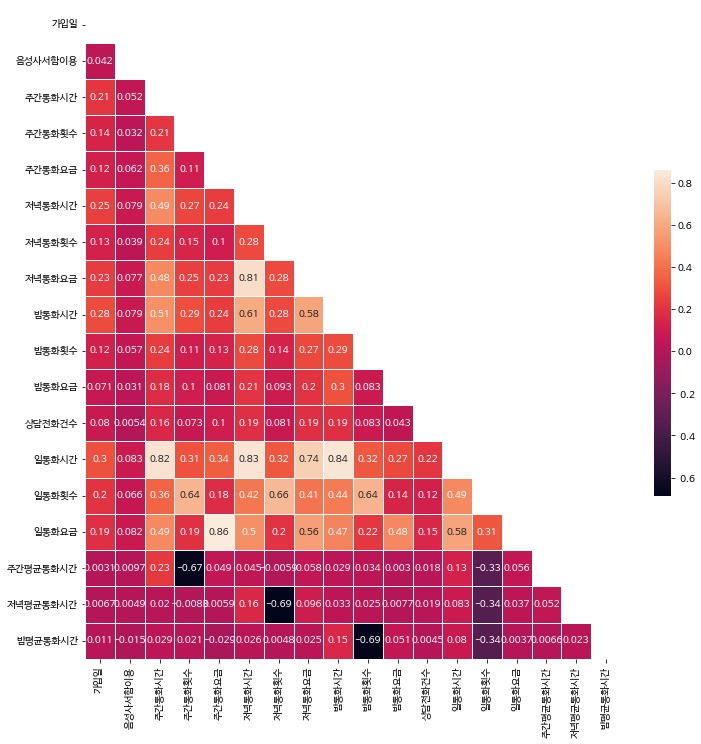

In [32]:
# 상관관계 확인
# cancel에는 consult_count, week_call_time이 큰 영향을 미침
# 독립변수들 간 상관관계가 높은 경우가 존재함
# call_count, call_time --> call_bill

train_corr = X.corr()
mask = np.zeros_like(train_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize = (12,12))

sns.heatmap(train_corr, annot =True, mask=mask, linewidth = 1, cbar_kws={'shrink' : 0.5})
plt.show()

In [33]:
for col in ['주간통화시간', '저녁통화시간', '밤통화시간']:
  test.loc[test[col] > 480.0, col] = 480.0

for col in ['가입일', '음성사서함이용', '주간통화요금', '밤통화요금']:
  test.loc[test[col] >= train_stats['highest_value'][col], col] = train_stats['highest_value'][col]

test['일통화시간'] = test['주간통화시간'] + test['저녁통화시간'] + test['밤통화시간']
test['일통화횟수'] = test['주간통화횟수'] + test['저녁통화횟수'] + test['밤통화횟수']
test['일통화요금'] = test['주간통화요금'] + test['저녁통화요금'] + test['밤통화요금']

test['주간평균통화시간'] = test['주간통화시간'] / test['주간통화횟수']
test['저녁평균통화시간'] = test['저녁통화시간'] / test['저녁통화횟수']
test['밤평균통화시간'] = test['밤통화시간'] / test['밤통화횟수']

test = test.fillna(0)
test.replace([np.inf, -np.inf], 0, inplace=True)
test_2 = test.drop(columns='ID')
test_cols = test_2.columns
test_2[test_cols] = scaler.transform(test_2[test_cols])

In [36]:
# X, y, test_2

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=42, test_size=0.2, stratify=y)
print(X_train.shape)
print(X_test.shape)
print('\n')
print(y_train.shape,'\t',y_test.shape)

(24160, 18)
(6040, 18)


(24160,) 	 (6040,)


In [39]:
# et_optuna

def et_optuna(trial):
  max_depth=trial.suggest_int('max_depth', 1, 40)
  min_samples_split = trial.suggest_int('min_samples_split', 2, 4)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 3)
  n_estimators = trial.suggest_int('n_estimators', 100, 1000)

  model = ExtraTreesClassifier(max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, n_estimators=n_estimators, 
                               n_jobs=-1, random_state=42)
  model.fit(X_train, y_train)
  score = f1_score(model.predict(X_test), y_test)

  return score

et_study = optuna.create_study(direction='maximize')
et_study.optimize(et_optuna, n_trials=5000)
print(f'Best Trial : {et_study.best_trial.value}, \nParams : {et_study.best_trial.params}')

[I 2023-03-27 02:44:32,398] A new study created in memory with name: no-name-27802cb7-1beb-4a11-bd18-fedb746f2a89
[I 2023-03-27 02:44:33,699] Trial 0 finished with value: 0.0 and parameters: {'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 3, 'n_estimators': 137}. Best is trial 0 with value: 0.0.
[I 2023-03-27 02:44:47,945] Trial 1 finished with value: 0.005988023952095808 and parameters: {'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1, 'n_estimators': 512}. Best is trial 1 with value: 0.005988023952095808.
[I 2023-03-27 02:45:17,468] Trial 2 finished with value: 0.5447545717035611 and parameters: {'max_depth': 26, 'min_samples_split': 3, 'min_samples_leaf': 1, 'n_estimators': 953}. Best is trial 2 with value: 0.5447545717035611.
[I 2023-03-27 02:45:31,669] Trial 3 finished with value: 0.0 and parameters: {'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 1, 'n_estimators': 875}. Best is trial 2 with value: 0.5447545717035611.
[I 2023-03-27 02:45:3

KeyboardInterrupt: ignored

In [ ]:
# xgb_optuna

def xgb_optuna(trial):
  max_depth=trial.suggest_int('max_depth', 1, 15)
  n_estimators = trial.suggest_int('n_estimators', 100, 1000)
  learning_rate = trial.suggest_float('learning_rate', 0.0001, 0.01)

  model = XGBClassifier(max_depth=max_depth, n_estimators=n_estimators, learning_rate=learning_rate,
                        n_jobs=-1, random_state=42)
  model.fit(X_train, y_train)
  score = f1_score(model.predict(X_test), y_test)

  return score

xgb_study = optuna.create_study(direction='maximize')
xgb_study.optimize(xgb_optuna, n_trials=5000)
print(f'Best Trial : {xgb_study.best_trial.value}, \nParams : {xgb_study.best_trial.params}')

In [ ]:
# cb_optuna

def cb_optuna(trial):
  max_depth=trial.suggest_int('max_depth', 1, 15)
  n_estimators = trial.suggest_int('n_estimators', 100, 1000)
  learning_rate = trial.suggest_float('learning_rate', 0.0001, 0.01)


  model = XGBClassifier(max_depth=max_depth, n_estimators=n_estimators, learning_rate=learning_rate,
                        verbose=0, n_jobs=-1, random_state=42)
  model.fit(X_train, y_train)
  score = f1_score(model.predict(X_test), y_test)

  return score

cb_study = optuna.create_study(direction='maximize')
cb_study.optimize(cb_optuna, n_trials=5000)
print(f'Best Trial : {cb_study.best_trial.value}, \nParams : {cb_study.best_trial.params}')

In [ ]:
# lgbm_optuna

def lgbm_optuna(trial):
  max_depth=trial.suggest_int('max_depth', 1, 15)
  n_estimators = trial.suggest_int('n_estimators', 100, 1000)
  learning_rate = trial.suggest_float('learning_rate', 0.0001, 0.01)


  model = LGBMClassifier(max_depth=max_depth, n_estimators=n_estimators, learning_rate=learning_rate,
                         n_jobs=-1, random_state=42)
  model.fit(X_train, y_train)
  score = f1_score(model.predict(X_test), y_test)

  return score

lgbm_study = optuna.create_study(direction='maximize')
lgbm_study.optimize(lgbm_optuna, n_trials=5000)
print(f'Best Trial : {lgbm_study.best_trial.value}, \nParams : {lgbm_study.best_trial.params}')

In [ ]:
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds):
    kf = KFold(n_splits=n_folds, shuffle=False, random_state=11)
    # 빈 배열 생성
    train_fold_pred = np.zeros((X_train_n.shape[0], 1))
    test_pred = np.zeros((X_test_n.shape[0], n_folds))
    
    
    for folder_counter, (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        print('폴드 세트 : ', folder_counter, ' 시작')
        X_tr = X_train_n[train_index]
        y_tr = y_train_n[train_index]
        X_te = X_train_n[valid_index] 
        
        # 폴드 내 모델 학습
        model.fit(X_tr, y_tr)
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1) # y_train 예측, 폴드 끝나면 concat해야함
        test_pred[:, folder_counter] = model.predict(X_test_n) # y_test 예측, 폴드 끝나면 평균 낼거임
        
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)
    
    return train_fold_pred, test_pred_mean # 하나의 모델에 대한 학습데이터, 테스트 데이터 생성

In [46]:
# Stacking with Tuned Model
# 파라미터 튜닝된 모델 4개를 가져와 스태킹 모델의 예측 변수로 생성

lgbm_params = {'max_depth': 10, 'learning_rate': 0.09,'random_state':42}
cb_params = {'max_depth': 8, 'learning_rate': 0.06800749578049192, 'n_estimators': 967, 'random_state':42}
xgb_params = {'max_depth': 10, 'learning_rate': 0.0493607891381531,'random_state':42}
et_params = {'n_estimators': 489, 'max_depth': 36, 'min_samples_split': 2, 'min_samples_leaf': 1, 'random_state':42}

et = ExtraTreesClassifier(**et_params, n_jobs=-1)
xgb = XGBClassifier(**xgb_params, n_jobs=-1)
cb = CatBoostClassifier(**cb_params, verbose=0)
lgbm = LGBMClassifier(**lgbm_params, n_jobs=-1)


estimators = [('et', et), ('xgb', xgb), ('cb', cb), ('lgbm', lgbm)]
stacked_model = StackingClassifier(estimators=estimators, final_estimator=lgbm)

kf = KFold(n_splits=25, shuffle=True, random_state=42)
meta_features = np.zeros((len(X), 4))  # 최종 분류기 모델에 들어갈 각 모델의 예측값을 저장하는 array

for train_idx, valid_idx in tqdm.tqdm(kf.split(X)):
    
    X_train_fold = X.iloc[train_idx]
    X_valid_fold = X.iloc[valid_idx]
    y_train_fold = y.iloc[train_idx]
    y_valid_fold = y.iloc[valid_idx]

    et.fit(X_train_fold, y_train_fold)
    xgb.fit(X_train_fold, y_train_fold)
    cb.fit(X_train_fold, y_train_fold)
    lgbm.fit(X_train_fold, y_train_fold)

    et_pred = et.predict_proba(X_valid_fold)[:, 1]
    xgb_pred = xgb.predict_proba(X_valid_fold)[:, 1]
    cb_pred = cb.predict_proba(X_valid_fold)[:, 1]
    lgbm_pred = lgbm.predict_proba(X_valid_fold)[:, 1]

    meta_features[valid_idx, 0] = et_pred
    meta_features[valid_idx, 1] = xgb_pred
    meta_features[valid_idx, 2] = cb_pred
    meta_features[valid_idx, 3] = lgbm_pred

stacked_model.fit(meta_features, y)

25it [24:14, 58.17s/it]


StackingClassifier(estimators=[('et',
                                ExtraTreesClassifier(max_depth=36,
                                                     n_estimators=489,
                                                     n_jobs=-1,
                                                     random_state=42)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, gamma=None,
                                              gpu...
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              n_estimators=100, n_jobs=-1,
                                              num_parallel_tree=None,
                                              predictor=None, random_state=42, ...)),
                               ('cb',
                                <catboost.core.CatBoostClassifier object at 0x7f83da3913d0>),
                               ('lgbm',
                                LGBMClassifier(learning_rate=0.09, max_depth=10,
                                               random_state=42))],
                   final_estimator=LGBMClassifier(learning_rate=0.09,
                                                  max_depth=10,
                                                  random_state=42))

In [47]:
# stacked_model의 test데이터에 대한 확률 계산
test_meta_features = np.column_stack((lgbm.predict_proba(test_2)[:, 1],
                                      cb.predict_proba(test_2)[:, 1],
                                      xgb.predict_proba(test_2)[:, 1],
                                      et.predict_proba(test_2)[:, 1]  
                                    ))

test_preds = stacked_model.predict_proba(test_meta_features)[:, 1]

In [48]:
# threshold값에 따른 binary 분류
threshold = 0.3
test_preds_binary = np.where(test_preds <= threshold, 0, 1)

In [49]:
sub['전화해지여부'] = test_preds_binary
sub.to_csv('result_8.csv', index=False)